# Aim

Get good and fast PSF fitting working, with the current models, in Python 3.8+. This could be using Theano, tf2+, or pytorch, and probably won't be using scipy.

1. (in the `oldeleanor` env) run code from master to show the baseline of fitting works
2. (in the `eleanorupgrade` env) set up frame-by-frame fitting in a new language, for sim data
3. the same as above for real data
4. set up all-at-once fitting using different weights for fluxes, and deviation-from-aperture regularization for coherence
5. the same as above for real data

In [1]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
%load_ext autoreload
%autoreload 2

In [92]:
# first, step 1: surgically extract code from afeinstein20/eleanor/master that still operates with my new API
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=11, 
    width=11, 
    do_pca=True, 
    do_psf=False,
)

In [109]:
data.psf_lightcurve(data_arr=tpfs, err_arr=errs, bkg_arr=bkgs, verbose=True, bkg_mag_cutoff=10, ignore_pixels=1)

100%|██████████| 900/900 [03:07<00:00,  4.79it/s]


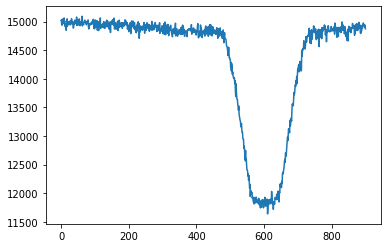

In [110]:
plt.plot(data.psf_flux[:,1])

In [122]:
tpfs_t = torch.tensor(tpfs.astype(np.float32))
errs_t = torch.tensor(errs.astype(np.float32))

In [111]:
pars0

array([1.58314727e+04, 1.58314727e+04, 1.58314727e+04, 0.00000000e+00,
       0.00000000e+00, 1.57312119e+02, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00])

In [113]:
nll = lambda mean_val, i: torch.sum(torch.div((mean_val - tpfs_t[i]) ** 2, errs_t[i]))

In [134]:
offset = len(tpfs) * nstars
def all_loss_and_grad(params):
    params = torch.tensor(params, requires_grad=True)
    xshift, yshift, bkg = params[offset:offset+3]
    optpars = params[offset+3:]
    loss = torch.tensor(0.)
    for i in range(len(tpfs)):
        mean_val = model.mean(params[i * nstars:(i + 1) * nstars], xshift, yshift, bkg, optpars)
        loss += nll(mean_val, i)
    gradient = tgrad(loss, params)
    loss = loss.detach().numpy()
    print(loss)
    return loss, gradient[0].detach().numpy()

In [119]:
pars0_all = np.hstack([pars0[0] * np.ones((len(tpfs)-1)*nstars), pars0])

In [137]:
overall_res = sopt.minimize(all_loss_and_grad, pars0_all, jac=True, method='TNC', tol=1e-4, options={'disp':True})

22087250000.0
22087250000.0
22087250000.0
20821789000.0
20821789000.0
20821789000.0
20393163000.0
22499693000.0
20863812000.0
20423217000.0
20346070000.0
20346070000.0
20346070000.0
20346070000.0
20346070000.0
20346070000.0
20346070000.0
20346070000.0
20346070000.0
20346067000.0
16694258000.0
16694258000.0
16694258000.0
16694258000.0
16503509000.0
16503509000.0
16503509000.0
16503509000.0
16503509000.0
16503509000.0
16503508000.0
16503509000.0
8472486400.0
7997406700.0
6689680000.0
6689669000.0
6689677000.0
6689679400.0
4777235000.0
4946277000.0
4638038000.0
4638037500.0
4638038000.0
4453474300.0
4453474300.0
4453474300.0
4453474300.0
4453474300.0
4453474300.0
4453474300.0
4453474000.0
4453473300.0
4453474300.0
3063191300.0
2569081600.0
2440144000.0
2440143400.0
2440143600.0
2440143600.0
2440144000.0
2209843700.0
2227175700.0
2190660600.0
2190660600.0
2190660600.0
2187176400.0
2187176200.0
2187176200.0
2187167000.0
2187167000.0
2187167000.0
2187167000.0
2185440500.0
2185440500.0
218544

In [138]:
overall_res

     fun: array(2.1850767e+09, dtype=float32)
     jac: array([ 6.89468513e-03, -1.19069339e-02,  1.25563313e-02, ...,
       -1.65743306e+05, -1.65231237e+05,  1.18713913e+04])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 95
     nit: 16
  status: 2
 success: True
       x: array([ 1.39484530e+04,  6.28851242e+04,  4.20283581e+04, ...,
        6.74631087e-01, -9.87147107e-02,  7.47999498e-01])

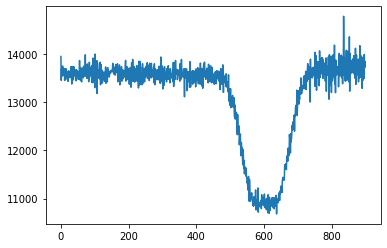

In [144]:
plt.plot(overall_res.x[:-6:nstars])